In [2]:
import cv2
import imutils
import numpy as np
import os
from imutils import paths


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report


import matplotlib.pyplot as plt

In [3]:
model = Sequential([
# input shape is the desired size of the image 224 x 224 with 3 bytes color
# This is the first convolution
Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
MaxPooling2D(2, 2),
# The second convolution
Conv2D(32, (3,3), activation='relu'),
MaxPooling2D(2,2),
# The third convolution
Conv2D(64, (3,3), activation='relu'),
MaxPooling2D(2,2),
# The fourth convolution
Conv2D(64, (3,3), activation='relu'),
MaxPooling2D(2,2),
# # The fifth convolution
Conv2D(64, (3,3), activation='relu'),
MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
Flatten(),
# 512 neuron hidden layer
Dense(512, activation='relu'),
Dense(2, activation="softmax")])

In [4]:
# initialize empty list for data(images) and labels
data = []
labels = []


print("[INFO] loading images...")
imagePaths = list(paths.list_images("Shield_Dataset/"))  # a list of paths of all images in the dataset 

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]  # check wheter the image is inside with_mask or without_mask folder
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

print("[INFO] images are loaded successfully!...")

lb = LabelBinarizer() # Binarize labels in a one-vs-all fashion
labels = lb.fit_transform(labels) # Fit label binarizer and transform multi-class labels to binary labels.
labels = to_categorical(labels) #Converts a class vector (integers) to binary class matrix.

# partition the data into training and testing splits 
# 80% of data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

# generate argumented images for training
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")


[INFO] loading images...
[INFO] images are loaded successfully!...


[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
60/60 [==============================] - 46s 768ms/step - loss: 0.5126 - acc: 0.7620 - val_loss: 0.3789 - val_acc: 0.8515
Epoch 2/20
60/60 [==============================] - 46s 768ms/step - loss: 0.3789 - acc: 0.8335 - val_loss: 0.2905 - val_acc: 0.8845
Epoch 3/20
60/60 [==============================] - 47s 786ms/step - loss: 0.3284 - acc: 0.8579 - val_loss: 0.3510 - val_acc: 0.8449
Epoch 4/20
60/60 [==============================] - 46s 774ms/step - loss: 0.2770 - acc: 0.8915 - val_loss: 0.1627 - val_acc: 0.9472
Epoch 5/20
60/60 [==============================] - 47s 775ms/step - loss: 0.2469 - acc: 0.9058 - val_loss: 0.1992 - val_acc: 0.9043
Epoch 6/20
60/60 [==============================] - 47s 776ms/step - loss: 0.2290 - acc: 0.9041 - val_loss: 0.1384 - val_acc: 0.9505
Epoch 7/20
60/60 [==============================] - 47s 7

ValueError: x and y must have same first dimension, but have shapes (19,) and (20,)

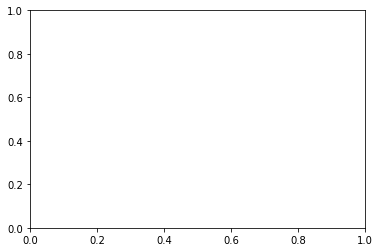

In [5]:
INIT_LR = 1e-4 # initial learning rate
EPOCHS = 20    #number of epochs
BS = 20  # batch size

# compile the model 
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


# train CNN model
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)




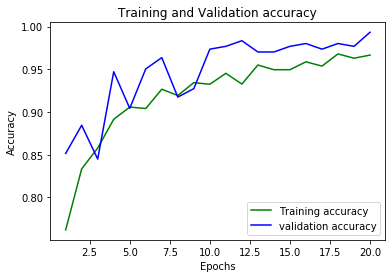

In [12]:

# Plot the training and validation accuracy 

loss_train = H.history['acc']
loss_val = H.history['val_acc']


epochs = range(1,EPOCHS+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)


# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))


[INFO] evaluating network...
                        precision    recall  f1-score   support

   Dataset/with_shield       0.99      0.99      0.99       152
Dataset/without_shield       0.99      0.99      0.99       151

              accuracy                           0.99       303
             macro avg       0.99      0.99      0.99       303
          weighted avg       0.99      0.99      0.99       303



In [14]:
# saving the model into disk
print("[INFO] saving mask detector model...")
model.save('shield_detector_OwnCNN.model')

[INFO] saving mask detector model...
